In [1]:
import torch
from torch.utils import data
from torch import nn
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
from IPython import display
# from alive_progress import alive_bar # alive-progress无法在jupyter正常显示
from tqdm import tqdm

In [2]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def get_dataloader_workers():
    return 12

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="./fashionmnist/data/fashion/", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="./fashionmnist/data/fashion/", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale) 
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize) 
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [3]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]
    
    
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [4]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [5]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.0)
        

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [6]:
# 交叉熵损失
loss = nn.CrossEntropyLoss(reduction='none')

In [7]:
# 优化算法
optim = torch.optim.SGD(net.parameters(), lr=0.1)

In [8]:
# 训练
def train(net, train_iter, loss, num_epochs, optim):
    for epoch in range(num_epochs):
        if isinstance(net, nn.Module):
            net.train()
        
        # 训练损失总和、训练准确度总和、样本数
        metric = Accumulator(3)
        
        progress_bar = tqdm(train_iter, desc='Processing', leave=True)
        for X, y in progress_bar:
            y_hat = net(X)
            l = loss(y_hat, y)
            optim.zero_grad()
            l.mean().backward()
            optim.step()
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

        print(f'epoch:{epoch}, train_loss:{metric[0] / metric[2]}, train_acc:{metric[1] / metric[2] }')
    print(f'Done!Finished {num_epochs} epochs.')

In [9]:
num_epochs = 20

train(net, train_iter, loss, num_epochs, optim)

Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 42.71it/s]


epoch:0, train_loss:0.7859454175949097, train_acc:0.7504


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 42.79it/s]


epoch:1, train_loss:0.5697654578526815, train_acc:0.81305


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 42.88it/s]


epoch:2, train_loss:0.5251002745946248, train_acc:0.8257


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 43.11it/s]


epoch:3, train_loss:0.5009782127380371, train_acc:0.8317666666666667


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 42.50it/s]


epoch:4, train_loss:0.4855273464202881, train_acc:0.83675


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 42.46it/s]


epoch:5, train_loss:0.47394230353037514, train_acc:0.8404666666666667


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 43.49it/s]


epoch:6, train_loss:0.46516500485738116, train_acc:0.8420166666666666


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 42.10it/s]


epoch:7, train_loss:0.45871856384277343, train_acc:0.8451833333333333


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 44.11it/s]


epoch:8, train_loss:0.45205503215789794, train_acc:0.8479333333333333


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 42.43it/s]


epoch:9, train_loss:0.4477367249806722, train_acc:0.8478


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 39.33it/s]


epoch:10, train_loss:0.442909330368042, train_acc:0.8500166666666666


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 43.16it/s]


epoch:11, train_loss:0.4395280007044474, train_acc:0.8505333333333334


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 42.14it/s]


epoch:12, train_loss:0.43665200379689534, train_acc:0.8518666666666667


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 42.21it/s]


epoch:13, train_loss:0.4331662516276042, train_acc:0.8515833333333334


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 41.53it/s]


epoch:14, train_loss:0.43064155044555663, train_acc:0.8528166666666667


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 41.60it/s]


epoch:15, train_loss:0.4279501095453898, train_acc:0.8538666666666667


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 41.54it/s]


epoch:16, train_loss:0.4259594482421875, train_acc:0.8543833333333334


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 41.76it/s]


epoch:17, train_loss:0.4240769224802653, train_acc:0.85555


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 41.92it/s]


epoch:18, train_loss:0.422171365737915, train_acc:0.85565


Processing: 100%|████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 41.97it/s]

epoch:19, train_loss:0.41995436935424807, train_acc:0.8559833333333333
Done!Finished 20 epochs.


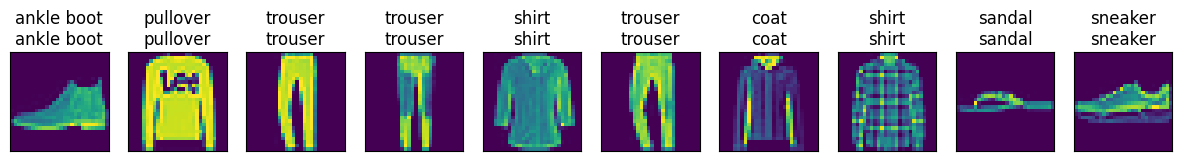

In [10]:
def predict(net, test_iter, n=10):
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape(n, 28, 28), 1, n, titles=titles[0:n])
    
predict(net, test_iter)